In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 27

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 42)                0         
_________________________________________________________________
dense (Dense)                (None, 20)                860       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 27)                297       
Total params: 1,367
Trainable params: 1,367
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
52/55 [===========================>..] - ETA: 0s - loss: 3.2620 - accuracy: 0.0657
Epoch 00001: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
55/55 [==============================] - 0s 4ms/step - loss: 3.2580 - accuracy: 0.0679 - val_loss: 3.1647 - val_accuracy: 0.1735
Epoch 2/1000
28/55 [==============>...............] - ETA: 0s - loss: 3.1517 - accuracy: 0.1451
Epoch 00002: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
55/55 [==============================] - 0s 2ms/step - loss: 3.1114 - accuracy: 0.1606 - val_loss: 2.9978 - val_accuracy: 0.1773
Epoch 3/1000
43/55 [======================>.......] - ETA: 0s - loss: 2.9740 - accuracy: 0.1828
Epoch 00003: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
55/55 [==============================] - 0s 2ms/step - loss: 2.9599 - accuracy: 0.1800 - val_loss: 2.8210 - val_accuracy: 0.1846
Epoch 4/1000
52/55 [===========================>..] - ETA: 0s - loss: 2.8403 - accura

In [12]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

 1/19 [>.............................] - ETA: 0s - loss: 0.9333 - accuracy: 0.7500WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0000s vs `on_test_batch_end` time: 0.0010s). Check your callbacks.


19/19 [==============================] - 0s 895us/step - loss: 0.9374 - accuracy: 0.7523


In [13]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [14]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[1.06331157e-02 1.13970316e-04 1.77075118e-02 5.43563347e-03
 3.88241489e-03 1.01522326e-01 2.37924177e-02 2.41186935e-03
 5.55649603e-06 5.80583870e-01 3.96387652e-02 2.71098506e-05
 2.86272389e-05 3.77827161e-03 1.32674584e-04 1.00034596e-02
 7.87458487e-10 6.12791862e-09 1.47647443e-04 1.39813632e-01
 1.15150733e-05 1.89280917e-03 2.30506714e-03 3.07035982e-04
 5.88410418e-04 5.44209518e-02 8.15277337e-04]
9


# Confusion matrix

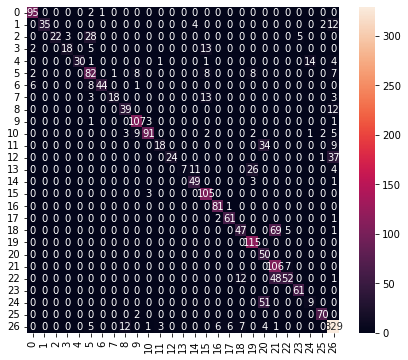

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.97      0.94        98
           1       1.00      0.66      0.80        53
           2       1.00      0.38      0.55        58
           3       0.86      0.47      0.61        38
           4       1.00      0.59      0.74        51
           5       0.61      0.71      0.65       116
           6       0.98      0.75      0.85        59
           7       0.95      0.49      0.64        37
           8       0.72      0.76      0.74        51
           9       0.84      0.96      0.90       112
          10       0.93      0.79      0.85       115
          11       0.82      0.30      0.43        61
          12       1.00      0.39      0.56        62
          13       1.00      0.15      0.25        48
          14       0.77      0.92      0.84        53
          15       0.74      0.97      0.84       108
          16       0.91      0.99      0.95        82
     

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [16]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [17]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\WONGCH~1\AppData\Local\Temp\tmpkqk9hisz\assets


7280

# Inference test

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [19]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

Wall time: 0 ns


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.0633113e-02 1.1397034e-04 1.7707516e-02 5.4356321e-03 3.8824156e-03
 1.0152229e-01 2.3792412e-02 2.4118701e-03 5.5564919e-06 5.8058399e-01
 3.9638743e-02 2.7109883e-05 2.8627301e-05 3.7782704e-03 1.3267448e-04
 1.0003456e-02 7.8745865e-10 6.1279311e-09 1.4764760e-04 1.3981362e-01
 1.1515087e-05 1.8928096e-03 2.3050688e-03 3.0703604e-04 5.8841083e-04
 5.4420926e-02 8.1527751e-04]
9
